<a href="https://colab.research.google.com/github/andydaehn/Drug_Classification/blob/main/Drug_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Drug Classification Analysis

This analysis will help predict the best drug to use for a particular patient, based on medical data from 200 patients, by classifying the patient to the drug profile.

## Import Libraries and Data

In [1]:
!pip install jupyter-dash

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.8 MB 38.3 MB/s 
     |████████████████████████████████| 357 kB 50.6 MB/s 
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11447 sha256=6ea030adcdd48ffe3cbcbc74652cbe36ca0a784315f4740cc55f60125b747aaa
  Stored in directory: /root/.cache/pip/wheels/f9/8d/8d/f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built retrying


In [3]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from IPython.display import display 

# Pretty display for notebooks
%matplotlib inline

# Ensure visualizations can be viewed by all
vis_color = 'colorblind'
hex_color = '#004c99'
cmap_color = 'jet'
color_discrete_sequence=['#de2d26','#fc9272','#fee0d2']


# Load the dataset
explore_df = pd.read_csv('drug200.csv')

## Exploratory Data Analysis

In [4]:
# Get basic information
display(explore_df.head())
display(explore_df.describe())
display(explore_df.info())


,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


,Age,Na_to_K
count,200.000000,200.000000
mean,44.315000,16.084485
std,16.544315,7.223956
min,15.000000,6.269000
25%,31.000000,10.445500
50%,45.000000,13.936500
75%,58.000000,19.380000
max,74.000000,38.247000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


None

### Univariate Analysis

In [5]:
# Imports for dashboards
import dash
import plotly.express as px
from jupyter_dash import JupyterDash
import dash_core_components as dcc
from dash import html
from dash.dependencies import Input, Output
import plotly.graph_objects as go

color_seq=px.colors.qualitative.Dark24

# Create the application
app = JupyterDash(__name__)

app.layout = html.Div(id = 'parent', children = [
        
        # Define dropdown
        dcc.Dropdown( id = 'dropdown',
        options = [{'label':c, 'value':c } for c in explore_df.columns],
            value = 'Na_to_K'),
            dcc.Graph(id = 'bar_plot')],
        style = {'width': '20%'})
    
@app.callback(Output(component_id='bar_plot', component_property= 'figure'),
              [Input(component_id='dropdown', component_property= 'value')])

# Update the graph on callback
def graph_update(dropdown_value):
    fig = px.histogram(x = explore_df['{}'.format(dropdown_value)],
                           title='Univariate Analysis',
                           labels={'x':dropdown_value},
                           nbins=30,
                           color_discrete_sequence=color_seq,
                           width=700,
                           height=500,)
    # Return the new graph
    return fig  

# Run app and display result inline in the notebook
app.run_server(mode='inline')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  """


<IPython.core.display.Javascript object>

**Inference:** Na_to_k has a positive skew. 

In [6]:
# Skewness
print("Skewness of Na_to_K: %f" % explore_df['Na_to_K'].skew())

Skewness of Na_to_K: 1.039341


**Inference**: Drug Y is widely used compared to other drugs.

### Bivariate Analysis

In [16]:
# Create the application
app = JupyterDash(__name__)

app.layout = html.Div([dcc.Graph(id = 'scatter_plot'),
    html.Div([
        
        # Define dropdown
        dcc.Dropdown( id = 'xaxis_dd',
        options = [{'label':c, 'value':c } for c in explore_df.columns],
            value = 'Drug')   
    ]),
    html.Div([
        
        # Define dropdown
        dcc.Dropdown( id = 'yaxis_dd',
        options = [{'label':c, 'value':c } for c in explore_df.columns],
            value = 'Na_to_K')
    ])
],style = {'width': '20%'})
    
@app.callback(Output(component_id='scatter_plot', component_property= 'figure'),
              [Input(component_id='xaxis_dd', component_property= 'value')],
              [Input(component_id='yaxis_dd', component_property= 'value')])

# Update the graph on callback
def graph_update(dropdown_value_one,dropdown_value_two):
    fig = px.scatter(explore_df,
                     x = explore_df['{}'.format(dropdown_value_one)],
                     y = explore_df['{}'.format(dropdown_value_two)],
                     color = 'Sex',
                     title='Bivariate Analysis',
                     labels={'x':dropdown_value_one,'y':dropdown_value_two},
                     color_discrete_sequence=color_seq,
                     width=700,
                     height=500,)
    # Return the new graph
    return fig  

# Run app and display result inline in the notebook
app.run_server(mode='inline')

<IPython.core.display.Javascript object>

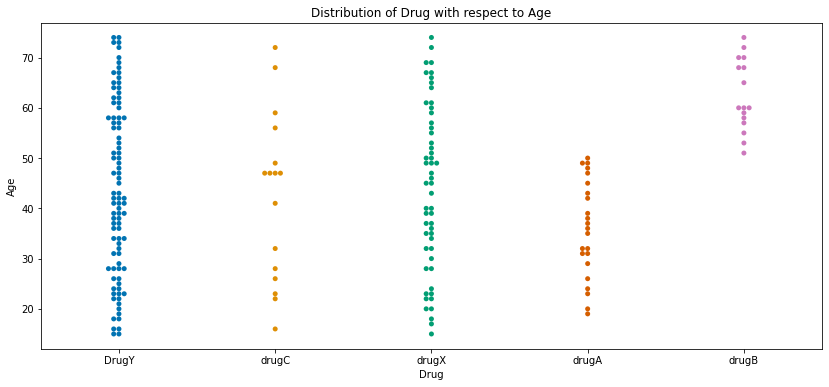

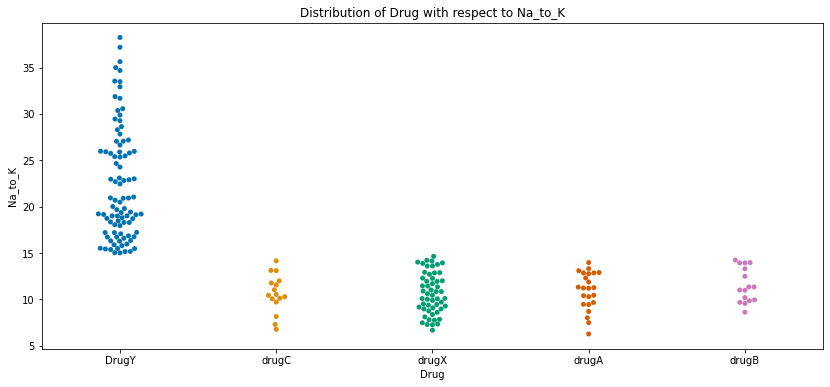

In [ ]:
# Bivariate for numerical columns
for col in numerical_cols:
    plt.figure(figsize=(14,6))
    sns.swarmplot(data=explore_df,x='Drug',y=col,palette=vis_color)
    plt.title(f"Distribution of Drug with respect to {col}")

**Inference:** Age may have a correlation with drugA and drugB. Na_to_K appears to have a high correlation to drugY.

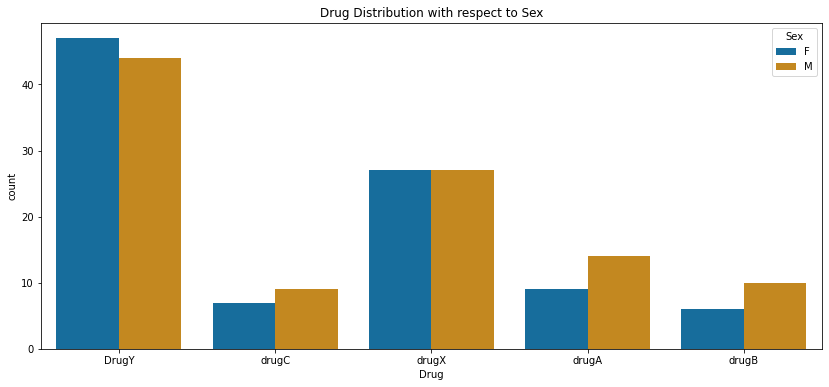

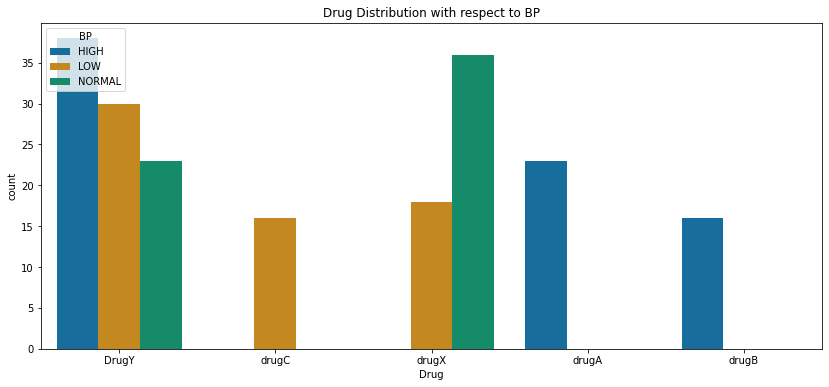

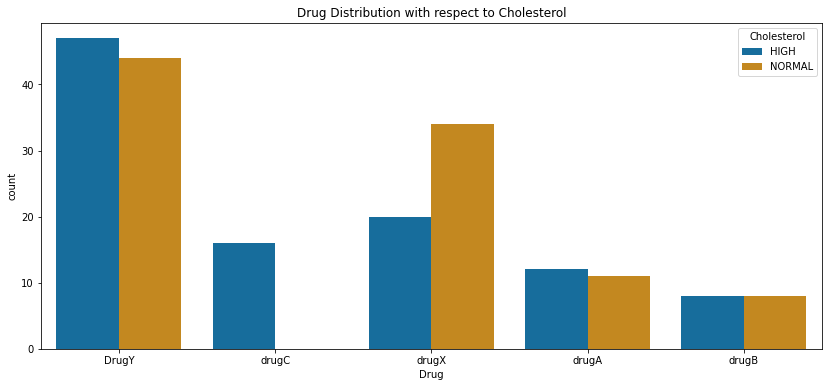

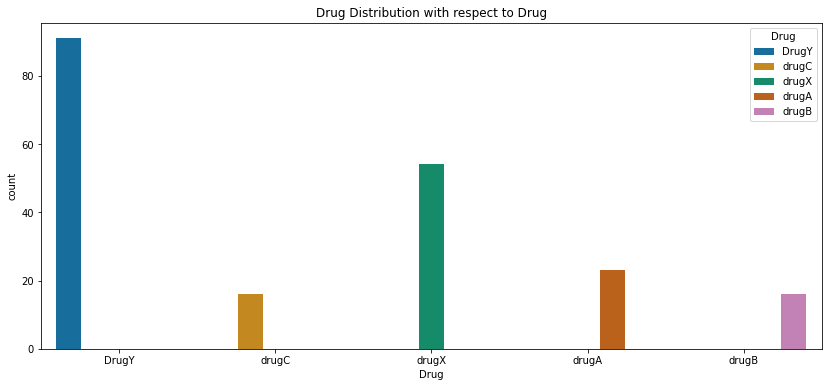

In [ ]:
# Bivariate for categorical columns
for col in categorical_cols:  
    plt.figure(figsize=(14,6))
    sns.countplot(data=explore_df,x='Drug',hue=col,palette=vis_color)
    plt.title(f"Drug Distribution with respect to {col}")

**Inference:** Sex appears to have little influence on which drug is used.

### Multivariate Analysis

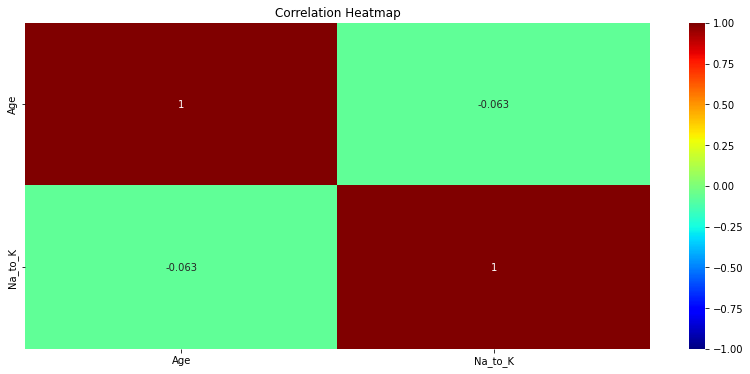

In [ ]:
# Create correlation matrix
plt.figure(figsize=(14, 6))
heatmap = sns.heatmap(explore_df.corr(), vmin=-1, vmax=1, annot=True, cmap=cmap_color)
heatmap.set_title('Correlation Heatmap');

Text(0.5, 1.0, 'Distribution of Drug with respect to Na_to_K and Blood Pressure')

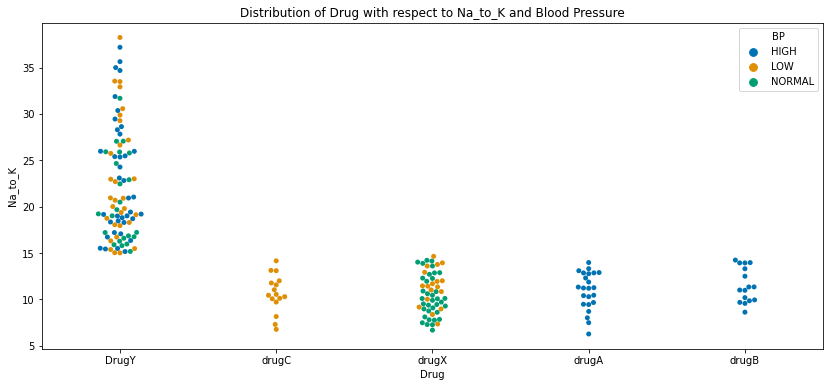

In [ ]:
# View the distrubution of drug compared with Na_to_K and BP
plt.figure(figsize=(14,6))
sns.swarmplot(data=explore_df,x='Drug',y='Na_to_K',hue='BP',palette=vis_color)
plt.title('Distribution of Drug with respect to Na_to_K and Blood Pressure')

## Data Wrangling


The original skewness of Na_to_K
Skewness: 1.039341


The new skewness of Na_to_K
Skewness: 0.673737


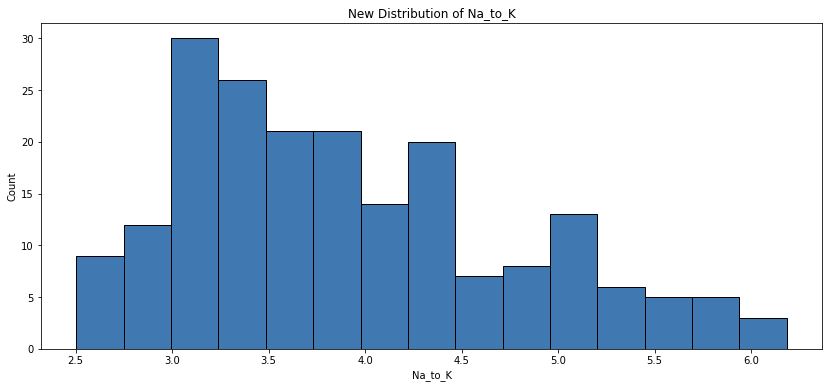

In [ ]:
# Handle the skewness in Na_to_K
print('The original skewness of Na_to_K')
print("Skewness: %f" % explore_df['Na_to_K'].skew())

print('\n')

# Use square root to adjust the skewness
explore_df['Na_to_K'] = np.sqrt(explore_df['Na_to_K'])

#Plot new
plt.figure(figsize=(14,6))
sns.histplot(data=explore_df,x='Na_to_K',bins=15,color=hex_color)
plt.title(f"New Distribution of Na_to_K")

print('The new skewness of Na_to_K')
print("Skewness: %f" % explore_df['Na_to_K'].skew())

In [ ]:
# Make a new column with Na_to_K greater than 15.0
explore_df['Na_to_K_Greater_Than_15'] = [1 if i >=15.015 else 0 for i in explore_df.Na_to_K]
explore_df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug,Na_to_K_Greater_Than_15
0,23,F,HIGH,HIGH,5.035375,DrugY,0
1,47,M,LOW,HIGH,3.618425,drugC,0
2,47,M,LOW,HIGH,3.180252,drugC,0
3,28,F,NORMAL,HIGH,2.792490,drugX,0
4,61,F,LOW,HIGH,4.247705,DrugY,0


In [ ]:
# Drop Sex and Cholesterol as they have little influence on the outcome
explore_df = explore_df.drop(['Sex','Cholesterol'],axis=1) 
explore_df.head()

,Age,BP,Na_to_K,Drug,Na_to_K_Greater_Than_15
0,23,HIGH,5.035375,DrugY,0
1,47,LOW,3.618425,drugC,0
2,47,LOW,3.180252,drugC,0
3,28,NORMAL,2.792490,drugX,0
4,61,LOW,4.247705,DrugY,0


In [ ]:
# Split data into features and target
y_df = explore_df['Drug']
X_df = explore_df.drop(['Drug'],axis=1)
X_df

,Age,BP,Na_to_K,Na_to_K_Greater_Than_15
0,23,HIGH,5.035375,0
1,47,LOW,3.618425,0
2,47,LOW,3.180252,0
3,28,NORMAL,2.792490,0
4,61,LOW,4.247705,0
...,...,...,...,...
195,56,LOW,3.401029,0
196,16,LOW,3.464968,0
197,52,NORMAL,3.145473,0
198,23,NORMAL,3.744329,0


## Split, Encode, Train, and Test the Data

In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=22)

In [ ]:
# Encode the data
X_train,X_test = [pd.get_dummies(df, columns=['BP']) for df in [X_train, X_test]]
y_train,y_test = [pd.get_dummies(df, columns=['Drug']) for df in [y_train, y_test]]

In [ ]:
# Train the data on the Random Forest Classifier and test the accuracy
rfc = RandomForestClassifier(n_estimators=5,max_depth=5)
rfc.fit(X_train,y_train)

# Making predictions
y_train_pred = rfc.predict(X_train)
y_test_pred = rfc.predict(X_test)

# Get Scores
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print('Results for Random Forest Classifier')
print('The training accuracy is',round((train_accuracy*100),2),'%')
print('The test accuracy is', round((test_accuracy*100),2),'%')


Results for Random Forest Classifier
The training accuracy is 95.0 %
The test accuracy is 87.5 %


In [ ]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98        20
           1       0.88      1.00      0.93         7
           2       1.00      0.75      0.86         4
           3       0.00      0.00      0.00         1
           4       0.83      0.62      0.71         8

   micro avg       0.88      0.88      0.88        40
   macro avg       0.73      0.68      0.70        40
weighted avg       0.90      0.88      0.88        40
 samples avg       0.88      0.88      0.88        40



In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=22)

In [ ]:
# Encode the data
X_train,X_test = [pd.get_dummies(df, columns=['BP']) for df in [X_train, X_test]]
y_train,y_test = [pd.get_dummies(df, columns=['Drug']) for df in [y_train, y_test]]

In [ ]:
# Train the data on the Decision Tree Classifier and test the accuracy
dtc = DecisionTreeClassifier(max_depth=5)
dtc.fit(X_train,y_train)

# Making predictions
y_train_pred = dtc.predict(X_train)
y_test_pred = dtc.predict(X_test)

# Get Scores
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print('Results for Decision Tree Classifier')
print('The training accuracy is',round((train_accuracy*100),2),'%')
print('The test accuracy is', round((test_accuracy*100),2),'%')

Results for Decision Tree Classifier
The training accuracy is 95.0 %
The test accuracy is 92.5 %


In [ ]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98        20
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         4
           3       0.33      1.00      0.50         1
           4       1.00      0.62      0.77         8

   micro avg       0.93      0.93      0.93        40
   macro avg       0.86      0.93      0.85        40
weighted avg       0.96      0.93      0.93        40
 samples avg       0.93      0.93      0.93        40

